In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
from tqdm import tqdm

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from feature_decomp import Monomial
from kernels import GaussianKernel, ExponentialKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy

kerneltype_dict = {
    "GaussianKernel": GaussianKernel,
    "ExponentialKernel": ExponentialKernel,
    "LaplaceKernel": LaplaceKernel,
}

In [17]:
# SETUP FILE MANAGEMENT
#######################

EXPT_NAME = "blah"
DATASET = "cifar10"

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET)

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [18]:
result = expt_fm.load("result.expt")

et_pathnames = ExptTrace.deserialize(result["pathnames"])
et_emp_eigvals = ExptTrace.deserialize(result["emp_eigvals"])
et_fra_eigvals = ExptTrace.deserialize(result["fra_eigvals"])

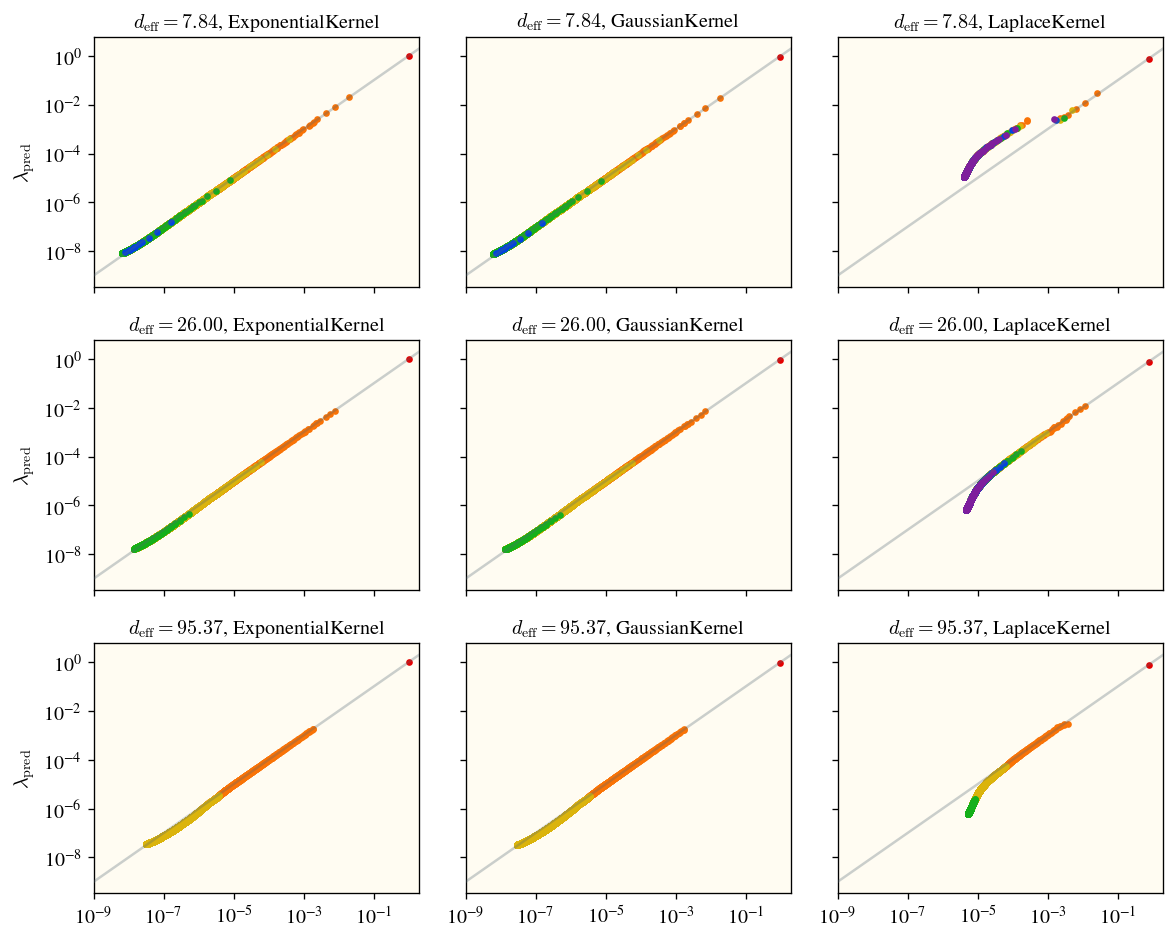

In [19]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
kerneltypes = et_pathnames.get_axis("kernel")
d_effs = et_pathnames.get_axis("d_eff")
d_effs = d_effs[:3]

fig, axes = plt.subplots(nrows=len(d_effs), ncols=len(kerneltypes),
                        figsize=(10, 8), sharex=True, sharey=True)

for i, d_eff in enumerate(d_effs):
    for j, kerneltype in enumerate(kerneltypes):
        subpath = et_pathnames[d_eff, kerneltype]
        expt_fm.set_filepath(subpath)
        monomials = expt_fm.load("monomials.pickle")
        degrees = np.array([Monomial(m).degree() for m in monomials])
        
        fra_eigvals = et_fra_eigvals[d_eff, kerneltype]
        emp_eigvals = et_emp_eigvals[d_eff, kerneltype]

        ax = axes[i, j]
        ax.set_title(f'$d_\mathrm{{eff}}={d_eff:.2f}$, {kerneltype}', fontsize=12)

        for degree in np.unique(degrees):
            if degree > 5:
                continue
            idxs = np.where(np.array(degrees) == degree)[0]
            ax.scatter(emp_eigvals[idxs], fra_eigvals[idxs],
                       color=colors[degree%7], marker='.')

        xmin, xmax = 1e-9, 2e0
        xx = np.linspace(xmin, xmax, 10)
        ax.set_xlim(xmin, xmax)
        ax.plot(xx, xx, color='xkcd:slate', alpha=0.3, zorder=4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 3:
            ax.set_xlabel(f'$\lambda_\mathrm{{emp}}$')
        if j == 0:
            ax.set_ylabel(f'$\lambda_\mathrm{{pred}}$')

plt.tight_layout()
plt.show()

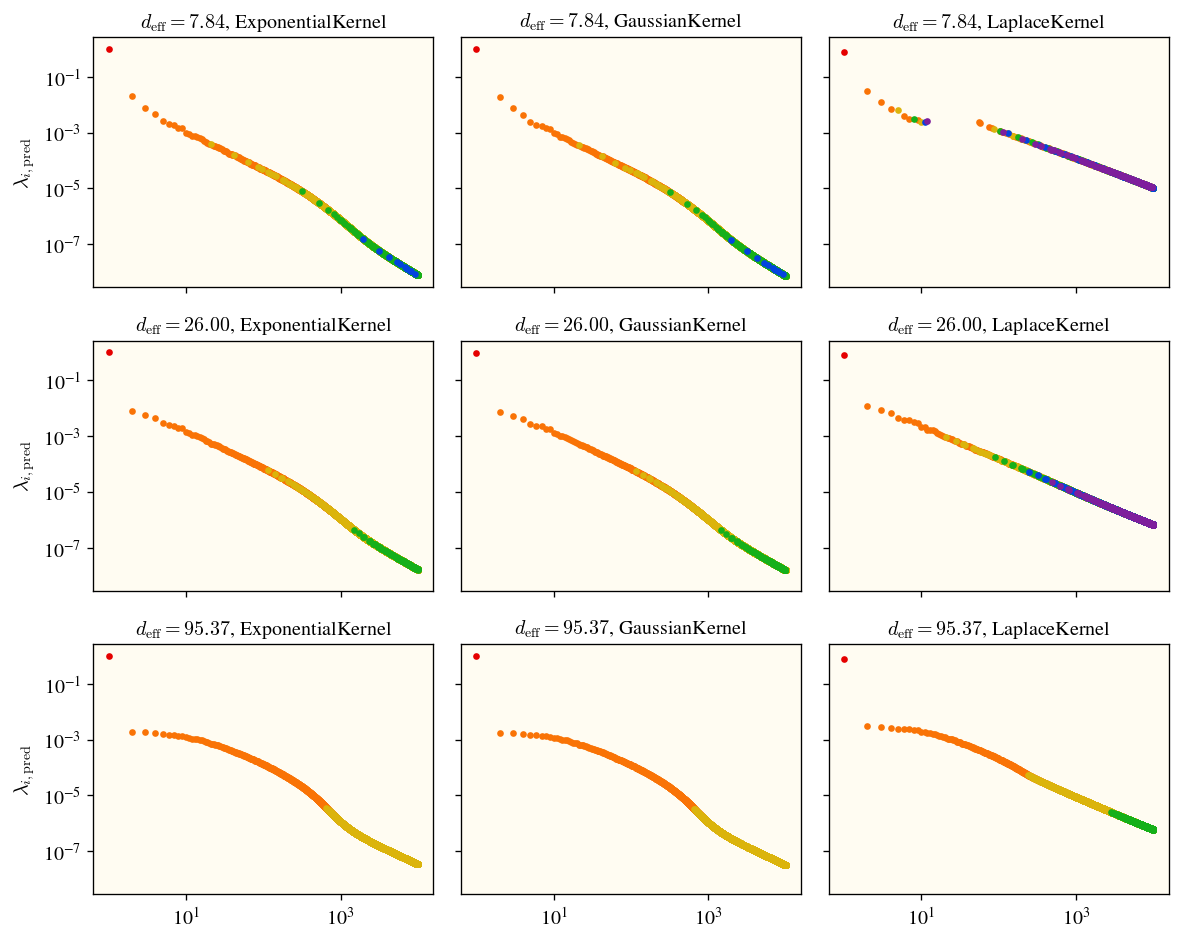

In [20]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
kerneltypes = et_pathnames.get_axis("kernel")
d_effs = et_pathnames.get_axis("d_eff")
d_effs = d_effs[:3]

fig, axes = plt.subplots(nrows=len(d_effs), ncols=len(kerneltypes),
                        figsize=(10, 8), sharex=True, sharey=True)

for i, d_eff in enumerate(d_effs):
    for j, kerneltype in enumerate(kerneltypes):
        subpath = et_pathnames[d_eff, kerneltype]
        expt_fm.set_filepath(subpath)
        monomials = expt_fm.load("monomials.pickle")
        degrees = np.array([Monomial(m).degree() for m in monomials])
        
        fra_eigvals = et_fra_eigvals[d_eff, kerneltype]
        emp_eigvals = et_emp_eigvals[d_eff, kerneltype]

        ax = axes[i, j]
        ax.set_title(f'$d_\mathrm{{eff}}={d_eff:.2f}$, {kerneltype}', fontsize=12)

        for degree in np.unique(degrees):
            if degree > 5:
                continue
            idxs = np.where(np.array(degrees) == degree)[0]
            ax.scatter(1+idxs, fra_eigvals[idxs],
                       color=colors[degree%7], marker='.')

        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 3:
            ax.set_xlabel(f'mode index $i$')
        if j == 0:
            ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')

plt.tight_layout()
plt.show()

...
...
...


/var/tmp/ipykernel_1757828/3045065816.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


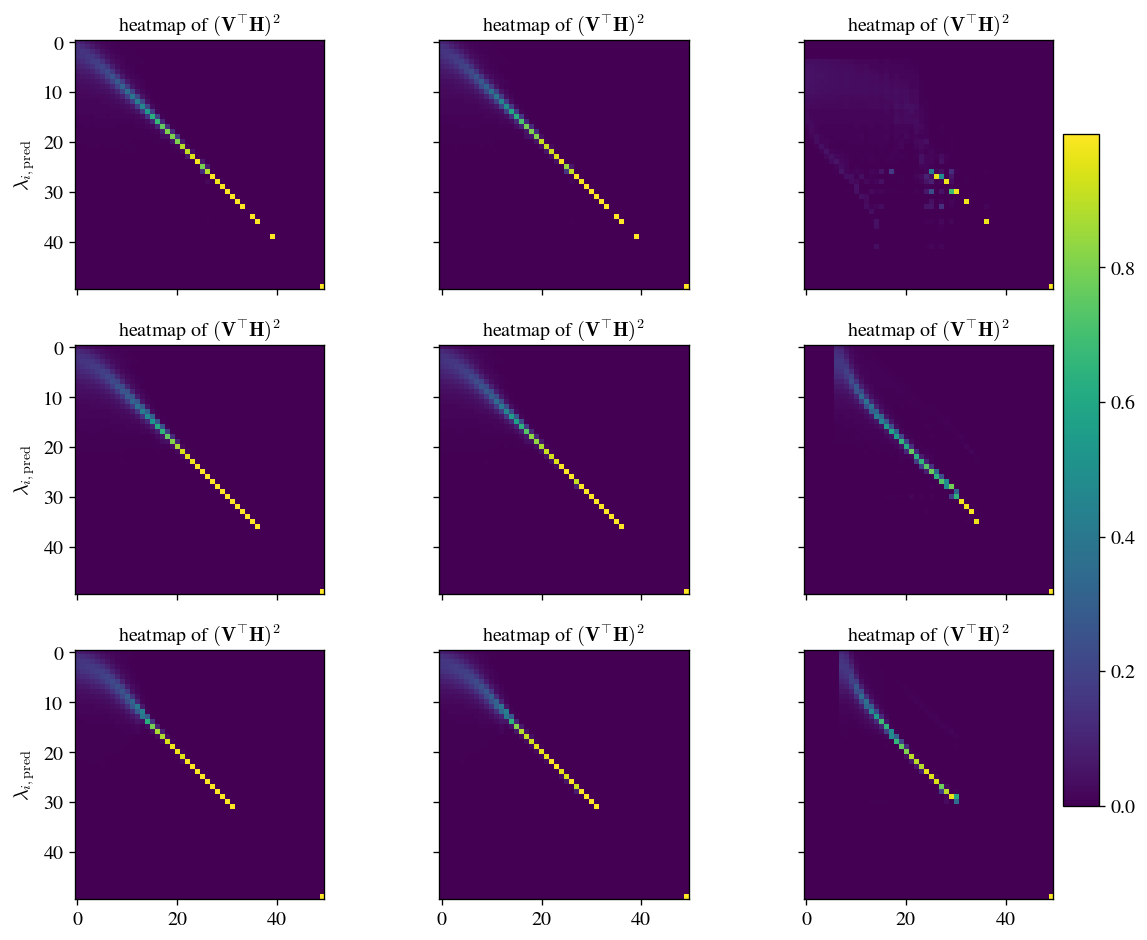

In [21]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
kernelnames = et_pathnames.get_axis("kernel")

d_effs = et_pathnames.get_axis("d_eff")
d_effs = d_effs[:3]

fig, axes = plt.subplots(nrows=len(d_effs), ncols=len(kernelnames),
                        figsize=(10, 8), sharex=True, sharey=True)

for i, d_eff in enumerate(d_effs):
    for j, kernelname in enumerate(kernelnames):
        print(".", end="")
        subpath = et_pathnames[d_eff, kernelname]
        expt_fm.set_filepath(subpath)
        kerneltype = kerneltype_dict[kernelname]
        kernel_data = expt_fm.load("kernel.pickle")
        eigvecs = ensure_torch(kernel_data["eigvecs"])
        del kernel_data
        H = ensure_torch(expt_fm.load("H.npy"))
        _, P_modes = H.shape
        M = (eigvecs[:, :P_modes].T @ H)**2
        del H
        M = ensure_numpy(M)
        
        fra_eigvals = et_fra_eigvals[d_eff, kernelname]
        emp_eigvals = et_emp_eigvals[d_eff, kernelname][:P_modes]
        
        all_eigvals = np.concatenate([fra_eigvals, emp_eigvals])
        all_eigvals = all_eigvals[all_eigvals>0]
        nbins = 50
        bin_edges = np.geomspace(max(1e-8, all_eigvals.min()), all_eigvals.max()+1e-5, num=(nbins+1))
        fra_bins = np.digitize(fra_eigvals, bin_edges) - 1
        emp_bins = np.digitize(emp_eigvals, bin_edges) - 1
        M_coarse = np.zeros((nbins, nbins))
        for mi in range(nbins):
            row_inds = np.where(fra_bins == mi)[0]
            for mj in range(nbins):
                col_inds = np.where(emp_bins == mj)[0]
                if len(row_inds) == 0 or len(col_inds) == 0:
                    continue
                block = M[np.ix_(row_inds, col_inds)]
                M_coarse[mi, mj] = block.sum() / len(col_inds)

        ax = axes[i, j]
        cbar = ax.imshow(M_coarse, aspect='equal', interpolation='nearest')
        ax.set_title(r'heatmap of $(\mathbf{V}^\top \mathbf{H})^2$', fontsize=12)
        
        if i == 3:
            ax.set_xlabel(f'mode index $i$')
        if j == 0:
            ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')
    print()

cax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
fig.colorbar(cbar, cax=cax)

plt.tight_layout()
plt.show()

In [19]:
import torch
torch.cuda.empty_cache()